<h1>CS4618: Artificial Intelligence I</h1>
<h1>Clustering: Continued</h1>
<h2>
    Derek Bridge<br>
    School of Computer Science and Information Technology<br>
    University College Cork
</h2>

<h1>Initialization</h1>
$\newcommand{\Set}[1]{\{#1\}}$ 
$\newcommand{\Tuple}[1]{\langle#1\rangle}$ 
$\newcommand{\v}[1]{\pmb{#1}}$ 
$\newcommand{\cv}[1]{\begin{bmatrix}#1\end{bmatrix}}$ 
$\newcommand{\rv}[1]{[#1]}$ 
$\DeclareMathOperator{\argmax}{arg\,max}$ 
$\DeclareMathOperator{\argmin}{arg\,min}$ 
$\DeclareMathOperator{\dist}{dist}$
$\DeclareMathOperator{\abs}{abs}$

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

from sklearn.cluster import AgglomerativeClustering

from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score

from scipy.cluster.hierarchy import dendrogram

# Class, for use in pipelines, to select certain columns from a DataFrame and convert to a numpy array
# From A. Geron: Hands-On Machine Learning with Scikit-Learn & TensorFlow, O'Reilly, 2017
# Modified by Derek Bridge to allow for casting in the same ways as pandas.DataFrame.astype
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names, dtype=None):
        self.attribute_names = attribute_names
        self.dtype = dtype
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X_selected = X[self.attribute_names]
        if self.dtype:
            return X_selected.astype(self.dtype).values
        return X_selected.values
    
# Function to convert the output of scikit-learn's AgglomerativeClustering into the linkage matrix required by
# scipy's dendrogram function
# It takes in the model fit by AgglomerativeClustering, plus all the usual arguments of the dendrogram
# function: https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.cluster.hierarchy.dendrogram.html
# Original by Mathew Kallada (BSD 3 licence), https://github.com/scikit-learn/scikit-learn/pull/3464/files
# Original computes numbers of children incorrectly
# Fixed by Derek Bridge 2017
def plot_dendrogram(model, **kwargs):
    tree_as_list = model.children_
    sizes = {}
    linkage_array = []
    start_idx = len(tree_as_list) + 1
    idx = start_idx
    for children in tree_as_list:
        linkage = []
        size = 0
        for child in children:
            linkage += [child]
            if child < start_idx:
                size += 1
            else:
                size += sizes.get(child)
        linkage += [idx - start_idx + 1, size] 
        sizes[idx] = size
        idx += 1
        linkage_array += [linkage]
    dendrogram(np.array(linkage_array).astype(float), **kwargs)

<h1>Hierarchical Clustering</h1>
<ul>
    <li>We'll look at a bottom-up, agglomerative algorithm, simply called <b>Agglomerative Clustering</b></li>
</ul>

<h1>Agglomerative Clustering</h1>
<figure style="border: 1px solid black; background-color: #D0D0D0">
    <figcaption style="border-bottom: 1px solid black">
        AgglomerativeClustering($\v{X}$)
    </figcaption>
    <ul>
        <li>Create a cluster for each $\v{x} \in \v{X}$;
        </li>
        <li>while there is more than one cluster 
            <ul>
                <li>choose two clusters;
                </li>
                <li>merge the two clusters into one;
                </li>
            </ul>
        </li>
        <li>return the tree of clusters;
        </li>
    </ul>
</figure>

<h1>Toy Example</h1>
<table>
    <tr style="border-bottom: 0">
        <td style="border-bottom: 0">Dataset $\v{X}$</td><td style="border-bottom: 0">Initial clusters</td>
        <td style="border-bottom: 0">Merge</td><td style="border-bottom: 0">Merge</td>
        <td style="border-bottom: 0">Merge</td><td style="border-bottom: 0">Merge</td>
        <td style="border-bottom: 0">Tree</td>
    </tr>
    <tr style="border-bottom: 0">
        <td style="border-top: 0"><img src="images/14_ag1.png" /></td>
        <td style="border-top: 0"><img src="images/14_ag2.png" /></td>
        <td style="border-top: 0"><img src="images/14_ag3.png" /></td>
        <td style="border-top: 0"><img src="images/14_ag4.png" /></td>
        <td style="border-top: 0"><img src="images/14_ag5.png" /></td>
        <td style="border-top: 0"><img src="images/14_ag6.png" /></td>
        <td style="border-top: 0"><img src="images/14_ag7.png" /></td>
    </tr>
</table>

<h1>Agglomerative Clustering</h1>
<ul>
    <li>How do we choose which to merge?
        <ul>
            <li>
                The pair of clusters for which the <b>linkage criterion</b> is <em>smallest</em>
            </li>
        </ul>
    </li>
    <li>Linkage criteria (for two clusters $\v{A}$ and $\v{B}$)
        <table>
            <tr><th>Name</th><th style="width:250px">Definition</th></tr>
            <tr><th>Complete-linkage clustering</th>
                <td>$\max \,\{\,\dist(a,b) : a\in A,\,b\in B\,\}$</td></tr>
            <tr><th>Average-linkage clustering</th>
                <td>$\frac{1}{|A||B|}\sum _{a\in A}\sum _{b\in B}\dist(a,b)$</td></tr>
        </table>
        (scikit-learn offers one more, which is called Ward's method, based on minimum variance, but it 
        only works for Euclidean distance. We'll ignore it, and all the others that you can find in the 
        literature!)
    </li>
    <li>We'll do an example using complete-linkage clustering and Euclidean distance</li>
</ul>

<h1>Example of complete-linkage clustering</h1>
<ul>
    <li>In effect, complete-linkage chooses to merge the two clusters that have the smallest maximum distances</li>
<table>
    <tr style="border-bottom: 0">
        <td style="border-bottom: 0">Which to merge?</td>
        <td style="border-bottom: 0">Distances</td>
        <td style="border-bottom: 0">Max</td>
        <td style="border-bottom: 0">Min</td>
    </tr>
    <tr style="border-bottom: 0">
        <td style="border-top: 0"><img src="images/14_cl1.png" /></td>
        <td style="border-top: 0"><img src="images/14_cl2.png" /></td>
        <td style="border-top: 0"><img src="images/14_cl3.png" /></td>
        <td style="border-top: 0"><img src="images/14_cl4.png" /></td>
    </tr>
</table>

<h1>Comparison</h1>
<ul>
    <li>They often produce the same clustering, especially when clusters are compact and quite separate</li>
    <li>Complete-linkage (min of the maximum distances):
        <ul>
            <li>Sensitive to outliers</li>
            <li>Some examples may be closer to other clusters than they are to the rest of their own cluster</li>
        </ul>
    </li>
    <li>Average-linkage (min of the averages)
        <ul>
            <li>Since it calculates with the distances (instead of just comparing them), it is more
                sensitive to the quality of your distance measure and your use of scaling
            </li>
        </ul>
    </li>
</ul>

<h1>Agglomerative clustering in scikit-learn</h1>
<ul>
    <li>We'll cluster the zoo dataset: 
        <a href="http://archive.ics.uci.edu/ml/datasets/zoo">http://archive.ics.uci.edu/ml/datasets/zoo</a>
    </li>
    <li>We explore the dataset using pandas and you'll see:
        <ul>
            <li>99 examples (I discarded 2)</li>
            <li>18 columns but we only use 16
                <ul>
                    <li>the first column is the animal name (we don't use it)</li>
                    <li>the last column is the result of manual clustering into 7 clusters (we don't use it
                        for clustering!)
                    </li>
                    <li>15 of the rest are Boolean (already binarized), whether the animal has feathers,
                        is a predator, etc.
                    </li>
                    <li>the remaining column is the number of legs (min 0, max 8 here): we min-max scale it
                    </li>
                </ul>
            </li>
        </ul>
    </li>
</ul>

In [4]:
# Use pandas to read the CSV file into a DataFrame
df = pd.read_csv("datasets/dataset_zoo.csv")

In [5]:
df.shape

(99, 18)

In [6]:
df.columns

Index(['name', 'hair', 'feathers', 'eggs', 'milk', 'airborne', 'aquatic',
       'predator', 'toothed', 'backbone', 'breathes', 'venomous', 'fins',
       'legs', 'tail', 'domestic', 'catsize', 'label'],
      dtype='object')

In [7]:
df.dtypes

name        object
hair         int64
feathers     int64
eggs         int64
milk         int64
airborne     int64
aquatic      int64
predator     int64
toothed      int64
backbone     int64
breathes     int64
venomous     int64
fins         int64
legs         int64
tail         int64
domestic     int64
catsize      int64
label        int64
dtype: object

In [8]:
df.head(3)

,name,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,label
0,aardvark,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
1,antelope,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1,1
2,bass,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0,4


In [9]:
# The features we want to select
numeric_features = ["legs"]
nominal_features = ["hair", "feathers", "eggs", "milk", "airborne", "aquatic", "predator", "toothed", 
                    "backbone", "breathes", "venomous", "fins", "tail", "domestic", "catsize"]

# Create the pipelines
numeric_pipeline = Pipeline([
        ("selector", DataFrameSelector(numeric_features, "float64")),
        ("scaler", MinMaxScaler())
    ])

nominal_pipeline = Pipeline([
        ("selector", DataFrameSelector(nominal_features))
    ])

pipeline = Pipeline([("union", 
                FeatureUnion([("numeric_pipeline", numeric_pipeline),
                              ("nominal_pipelines", nominal_pipeline)]))])

In [10]:
# Run the pipeline
pipeline.fit(df)
X = pipeline.transform(df)

In [11]:
# Create the clustering object
agg_complete = AgglomerativeClustering(linkage="complete") # The alternative is linkage="average"

In [12]:
# Run it and store the result in a variable
clustering_complete = agg_complete.fit(X)

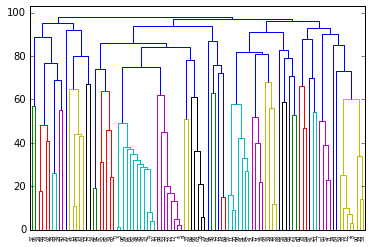

In [13]:
# Draw the tree: not very informative!
fig = plt.figure()
plot_dendrogram(clustering_complete)
plt.show()

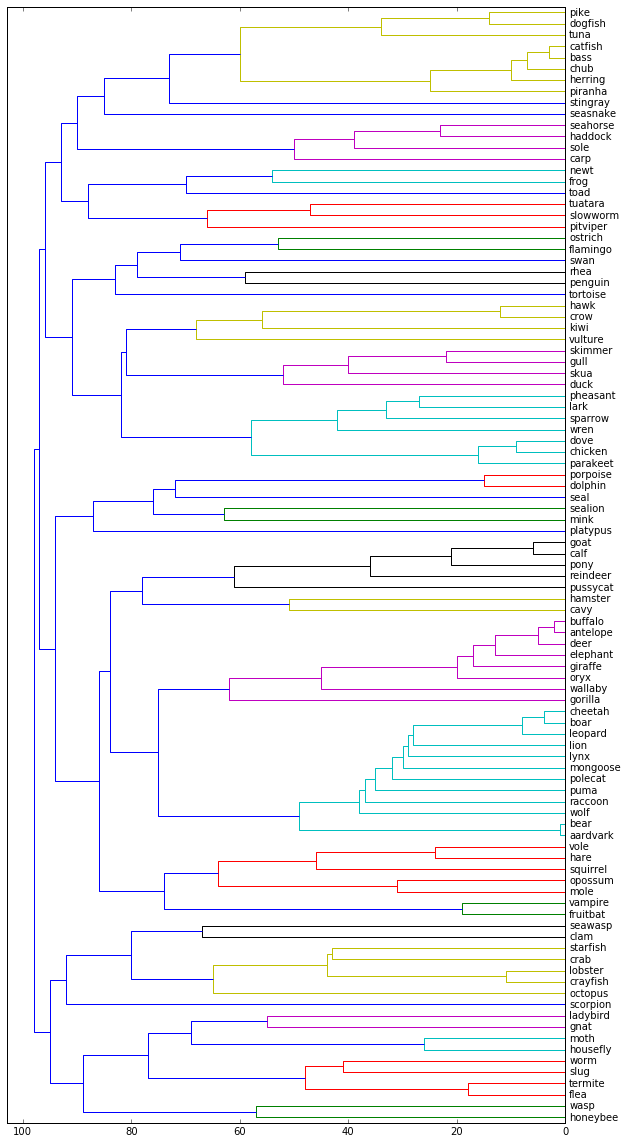

In [14]:
# Draw the tree but using some extra parameters
# See https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.cluster.hierarchy.dendrogram.html

names = df["name"] # the animal name from the original dataset

def llf(id):
    return names[id]
    
fig = plt.figure(figsize=(10,20))
plot_dendrogram(clustering_complete, orientation="left", leaf_label_func=llf, leaf_font_size=10)
plt.show()

<h1>Agglomerative Clustering: Discussion</h1>
<ul>
    <li>You don't have to run the algorithm to completion. You could exit early:
        <ul>
            <li>when you have a certain number of clusters, $k < m$</li>
            <li>or when the next merge would result in a 'bad' cluster, using some measure such as max distance
                within a cluster
            </li>
         </ul>
     </li>
    <li>This algorithm is only suitable for relatively small datasets
        <ul>
            <li>You would probably calculate the distance between every pair of objects in advance</li>
            <li>But, in every iteration, it compares every cluster with every other</li>
            <li>In the first iteration, that's $m^2$, then $(m-1)^2$, then $(m-2)^2$, &hellip; until we have
                just one cluster
            </li>
            <li>That's $O(m^3)$</li>
            <li>A smarter implementation only compares the new cluster with existing
                ones at each step, keeping track of the linkage distances between pairs in a priority-ordered 
                queue, and taking $O(m^2\log m)$
            </li>
        </ul>
    </li>
    <li>Advanced: You can define 'connectivity constraints' which forbid the merging of certain examples
        with certain others
        <ul>
            <li>This allows you to incorporate domain-specific knowledge or preferences</li>
            <li>E.g. only cluster together web pages that link to each other</li>
             <li>It then often runs faster too</li>
         </ul>
    </li>
</ul>

<h1>Evaluating clustering, part 2</h1>
<ul>
    <li>We've seen one way to evaluate the quality of clustering
        <ul>
            <li>Using a score, such as Silhouette Score</li>
        </ul>
    </li>
    <li>There is another way &mdash; if you have a 'ground truth':
        <ul>
            <li>I.e. if someone has already clustered the dataset manually</li>
        </ul>
        Then we can compare the algorithm's clustering with the manual one
    </li>
    <li>In many cases, this would be absurd: if we have clustered manually, then we don't need an algorithm!
        <ul>
            <li>But a researcher who develops a new algorithm might test it against manual clustering</li>
            <li>And, even in industry, sometimes we will have manually clustered a subset of the dataset,
                which we can use for evaluating the algorithm's clustering
            </li>
        </ul>
    </li>
    <li>E.g. the <b>Adjusted Rand Score</b> compares two clusterings
        <ul>
            <li>For each pair $\v{x}, \v{x}'$ in $\v{X}$, it counts up whether the two clusterings agree
                (they put $\v{x}$ and $\v{x}'$ into the same cluster) or not
            </li>
            <li>It divides by the number of pairs</li>
            <li>There is then an adjustment to 'correct for chance'</li>
            <li>The adjusted rand score lies in $[-1, 1]$</li>
        </ul>
    </li>  
</ul>

In [15]:
# Evaluate it
silhouette_score(X, agg_complete.labels_, metric='euclidean')

0.21840801955460787

In [16]:
# Interestingly, average-linkage is better
agg_average = AgglomerativeClustering(linkage="average")
clustering_average = agg_average.fit(X)
silhouette_score(X, agg_average.labels_, metric='euclidean')

0.32614762928188862

In [17]:
# Manual labels
ground_truth = df["label"] 

<ul>
    <li>The manual clustering has 7 clusters (1-7)</li>
    <li>So, to be fair, we should get <code>AgglomerativeClustering</code> to do the same</li>
</ul>

In [18]:
agg_complete = AgglomerativeClustering(linkage="complete", n_clusters=7)
clustering_complete = agg_complete.fit(X)

adjusted_rand_score(ground_truth, agg_complete.labels_)

0.82704538827108443

In [19]:
agg_average = AgglomerativeClustering(linkage="average", n_clusters=7)
clustering_average = agg_average.fit(X)

adjusted_rand_score(ground_truth, agg_average.labels_)

0.94979253112033191

In [20]:
# And, for curiosity, how much do they agree with each other
adjusted_rand_score(agg_complete.labels_, agg_average.labels_)

0.87324976530623744

<h1>Final Remarks on Clustering</h1>
<ul>
    <li>There are numerous other clustering algorithms</li>
    <li>There are numerous other ways of scoring clusterings to evaluate them</li>
    <li>But it's time for us to move on&hellip;</li>
</ul>